In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from scipy.stats import norm

In [17]:
# Load the dataset
df = pd.read_excel("C:/Users/SAPTARSHI/Downloads/red_light_violation.xlsx")

In [18]:
df.head()

,Timestamp,Name,Email,Age Group,Gender,Occupation,Approximate monthly income of the person who violates traffic signals\n,Education level\n,Driving Experience,How often do your friends describe you as argumentative?,...,What are the main reasons that make you more likely to cross during a red light?.1,Do you believe that adding countdown timers effect on red light violation?\n,"What strategies or policies might make you less likely to run a red light , and which measures do you think would most effectively reduce red light running?",When do you believe red light violations are most common?,Which type of vehicle is more likely to violate red light?,Which type of intersections do you believe is most prone to red light violations?,What type of public awareness campaign would be most likely to influence your driving behaviour regarding red light running ?,When do you believe red light violations are most common?.1,Which type of vehicle is more likely to violate red light?.1,Which type of intersections do you believe is most prone to red light violations?.1
0,10/22/2024 19:57:38,Sourav Dutta,NaN,19 - 29,Male,Employed,20k -50k,Post -Graduation and above,More than 5 years,Moderate,...,NaN,NaN,NaN,NaN,NaN,NaN,"Ads on TV,radio,or online",Weekdays during peak traffic hours,Auto Rickshaw,Circular intersections
1,10/22/2024 21:24:05,Saptarshi Khan,NaN,19 - 29,Male,Student,Less than 20 k,Graduation,0 -1 year,Moderate,...,To save time or avoid long waits,"Yes ,but only slightly",More police enforcement,Weekdays during peak traffic hours,Auto rickshaw,All of the above,NaN,NaN,NaN,NaN
2,10/22/2024 22:01:21,Saptarshi Khan,NaN,19 - 29,Male,Student,Less than 20 k,Graduation,NaN,Moderate,...,To save time or avoid long waits,"Yes ,but only slightly",More police enforcement,Weekdays during peak traffic hours,Auto rickshaw,All of the above,NaN,NaN,NaN,NaN
3,10/23/2024 0:17:38,Abhijeet Murmu,abhi.phena@gmail.com,19 - 29,Male,Student,20k -50k,Graduation,More than 5 years,Moderate,...,NaN,NaN,NaN,Weekdays during non -peak or late night hours,Motorcycles,Circular intersections,NaN,NaN,NaN,NaN
4,10/23/2024 0:18:49,Pavan ALAPATI,pavanalapati9@gmail.com,19 - 29,Male,Student,50k - 1 lakh,Graduation,1- 5 years,Moderate,...,To save time or avoid long waits,"Yes,it would help a lot",Better traffic signal timing,Weekdays during peak traffic hours,Motorcycles,All of the above,NaN,NaN,NaN,NaN


In [19]:
# Drop irrelevant columns
df_cleaned = df.drop(columns=["Timestamp", "Name", "Email"], errors='ignore')


In [20]:
# Encode target variable (Yes -> 1, No -> 0)
df_cleaned["RedLightViolation"] = df_cleaned["Have you ever crossed the street during a red light?"].map({"Yes": 1, "No": 0})

In [21]:
# Drop original target column
df_cleaned = df_cleaned.drop(columns=["Have you ever crossed the street during a red light?"], errors='ignore')


In [46]:
# Define column groups
demographic_cols = ["Age Group", "Gender", "Occupation", "Approximate monthly income of the person who violates traffic signals", "Education level"]
psychological_cols = ["How often do your friends describe you as argumentative?", "Do you openly express disagreement with your friends?", "Do you find yourself getting into arguments when people disagree with you?", "Do you get into physical fights more frequently than the average person?", "Have you ever been so angry that you broke something?"]
driving_experience_cols = ["Driving Experience", "How many hours a day do you usually drive?"]
traffic_external_cols = ["In which areas do you think red light violations are more of a problem?", "What are the main reasons that make you more likely to cross during a red light?", "Do you believe that adding countdown timers to traffic lights would reduce red light violations?", "What strategies or policies might make you less likely to run a red light?"]
perception_cols = ["How do you react when you see someone running a red light?", "When do you believe red light violations are most common?", "Which type of vehicle is more likely to violate red light?", "Which type of intersections do you believe is most prone to red light violations?", "What type of public awareness campaign would be most likely to influence your driving behaviour regarding red light running?"]

In [35]:
# Selected columns for sensitivity analysis
selected_cols = ["Age Group", "Gender", "Approximate monthly income of the person who violates traffic signals\n",
                 "Do you find yourself getting into arguments when people disagree with you?",
                 "Driving Experience",
                 "Which type of intersections do you believe is most prone to red light violations?",
                 "What are the main reasons that make you more likely to cross during a red light?"]


In [34]:
print(df_cleaned.columns)

Index(['Age Group', 'Gender', 'Occupation',
       'Approximate monthly income of the person who violates traffic signals\n',
       'Education level\n', 'Driving Experience',
       'How often do your friends describe you as argumentative?',
       'Do you openly express disagreement with your friends?',
       'Do you find yourself getting into arguments when people disagree with you?',
       'Do you get into physical fights more frequently than the average person?',
       'Have you ever been so angry that you broke something?',
       'How do you react when you see someone running a red light?',
       'How many hours a day do you usually drive?',
       'In which areas do you think red light violations are more of a problem ?',
       'What are the main reasons that make you more likely to cross during a red light?',
       'Do you believe that adding countdown timers to traffic lights would reduce red light violations?\n',
       'What strategies or policies might make you less 

In [36]:
# Function to preprocess data
def preprocess_data(selected_col):
    if selected_col not in df_cleaned.columns:
        print(f"Warning: {selected_col} not found in dataset. Skipping...")
        return None  # Return None to avoid errors

    X_factor = df_cleaned[[selected_col]].copy()
    
    # Check if column has valid data before encoding
    if X_factor.empty or X_factor.isnull().all().all():
        print(f"Warning: {selected_col} has no valid data. Skipping...")
        return None

    X_factor_encoded = pd.get_dummies(X_factor, drop_first=True)

    imputer = SimpleImputer(strategy="most_frequent")
    X_factor_imputed = pd.DataFrame(imputer.fit_transform(X_factor_encoded), columns=X_factor_encoded.columns)

    return X_factor_imputed

In [37]:
def analyze_sensitivity(selected_cols):
    for col in selected_cols:
        X = preprocess_data(col)
        if X is None:
            continue  # Skip to the next column if preprocessing fails

        y = df_cleaned["RedLightViolation"]
        X = sm.add_constant(X)  # Add intercept

        model = sm.Logit(y, X)
        result = model.fit()

        print(f"\nLogit Model Summary - Sensitivity Analysis for {col}\n")
        print(result.summary())

        # Extract coefficients
        coef = result.params.iloc[1:]  # Skip intercept
        coef_df = coef.to_frame()
        coef_df.columns = ['Coefficient']

        # Plot sensitivity as a line chart
        plt.figure(figsize=(8, 5))
        coef_df.sort_values(by='Coefficient', ascending=False).plot(kind='line', marker='o', linestyle='-', color='b', legend=False)
        plt.title(f"Feature Sensitivity in Predicting Red Light Violation ({col})")
        plt.xlabel("Categories")
        plt.ylabel("Coefficient Value")
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

Optimization terminated successfully.
         Current function value: 0.530624
         Iterations 7

Logit Model Summary - Sensitivity Analysis for Age Group

                           Logit Regression Results                           
Dep. Variable:      RedLightViolation   No. Observations:                  800
Model:                          Logit   Df Residuals:                      796
Method:                           MLE   Df Model:                            3
Date:                Thu, 06 Mar 2025   Pseudo R-squ.:                 0.04697
Time:                        23:46:34   Log-Likelihood:                -424.50
converged:                       True   LL-Null:                       -445.42
Covariance Type:            nonrobust   LLR p-value:                 4.336e-09
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.5333    

C:\Users\SAPTARSHI\anaconda3\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


<Figure size 800x500 with 0 Axes>

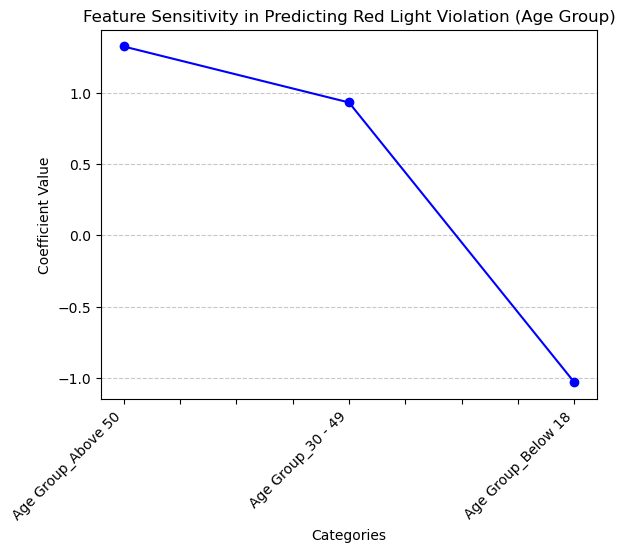

         Current function value: 0.544956
         Iterations: 35

Logit Model Summary - Sensitivity Analysis for Gender

                           Logit Regression Results                           
Dep. Variable:      RedLightViolation   No. Observations:                  800
Model:                          Logit   Df Residuals:                      797
Method:                           MLE   Df Model:                            2
Date:                Thu, 06 Mar 2025   Pseudo R-squ.:                 0.02123
Time:                        23:46:34   Log-Likelihood:                -435.97
converged:                      False   LL-Null:                       -445.42
Covariance Type:            nonrobust   LLR p-value:                 7.829e-05
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.9828      0.245     -8.103      0.000      -2.462      -1.503
Gen

C:\Users\SAPTARSHI\anaconda3\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
C:\Users\SAPTARSHI\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 800x500 with 0 Axes>

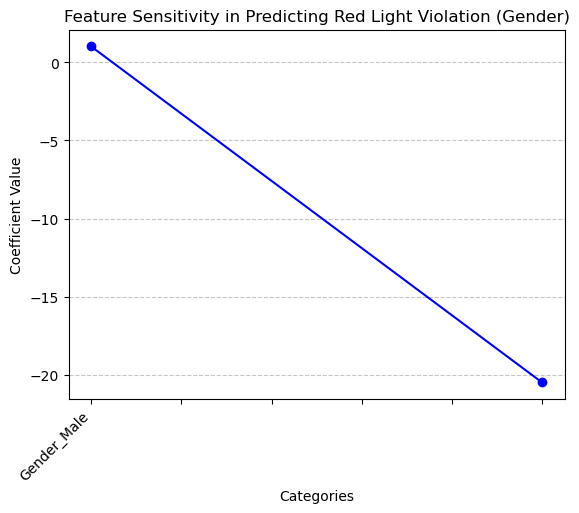

C:\Users\SAPTARSHI\anaconda3\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


Optimization terminated successfully.
         Current function value: 0.545710
         Iterations 5

Logit Model Summary - Sensitivity Analysis for Approximate monthly income of the person who violates traffic signals


                           Logit Regression Results                           
Dep. Variable:      RedLightViolation   No. Observations:                  800
Model:                          Logit   Df Residuals:                      795
Method:                           MLE   Df Model:                            4
Date:                Thu, 06 Mar 2025   Pseudo R-squ.:                 0.01987
Time:                        23:46:34   Log-Likelihood:                -436.57
converged:                       True   LL-Null:                       -445.42
Covariance Type:            nonrobust   LLR p-value:                  0.001410
                                                                                                  coef    std err          z      P>|z|      [0.02

<Figure size 800x500 with 0 Axes>

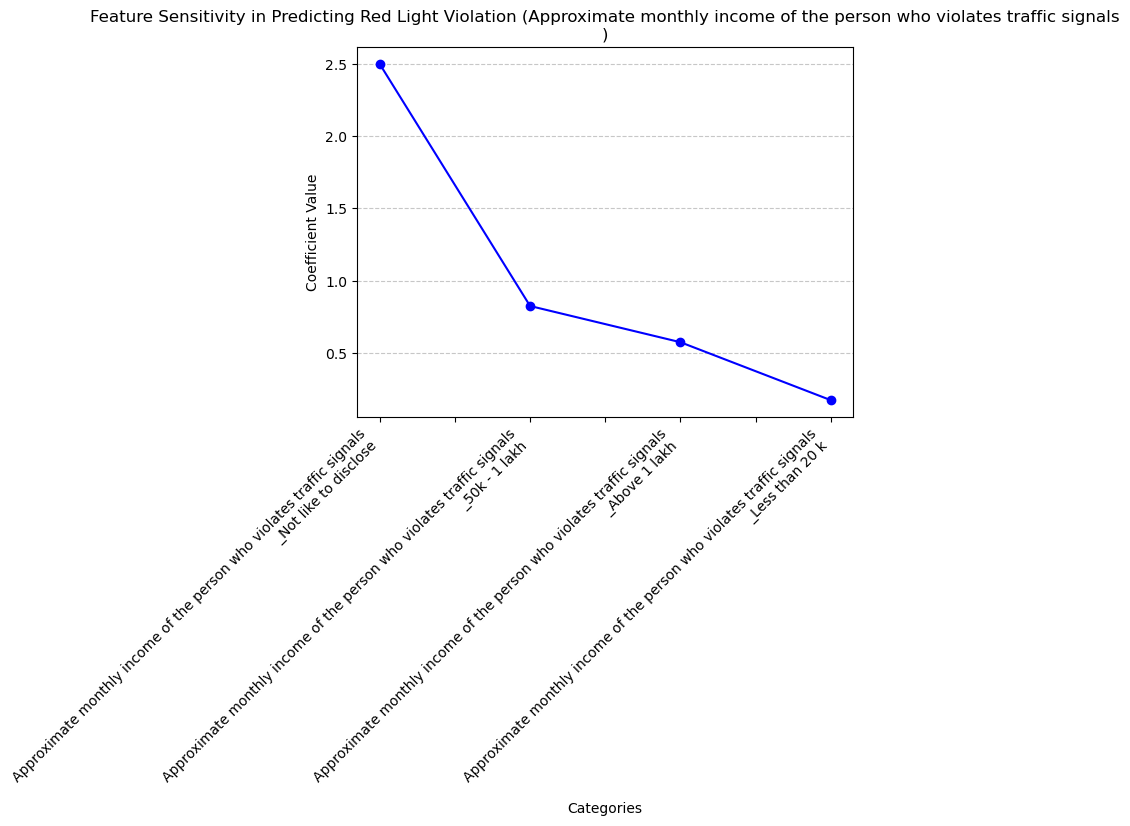

Optimization terminated successfully.
         Current function value: 0.518538
         Iterations 6

Logit Model Summary - Sensitivity Analysis for Do you find yourself getting into arguments when people disagree with you?

                           Logit Regression Results                           
Dep. Variable:      RedLightViolation   No. Observations:                  800
Model:                          Logit   Df Residuals:                      797
Method:                           MLE   Df Model:                            2
Date:                Thu, 06 Mar 2025   Pseudo R-squ.:                 0.06868
Time:                        23:46:34   Log-Likelihood:                -414.83
converged:                       True   LL-Null:                       -445.42
Covariance Type:            nonrobust   LLR p-value:                 5.189e-14
                                                                                           coef    std err          z      P>|z|      [0.025  

C:\Users\SAPTARSHI\anaconda3\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


<Figure size 800x500 with 0 Axes>

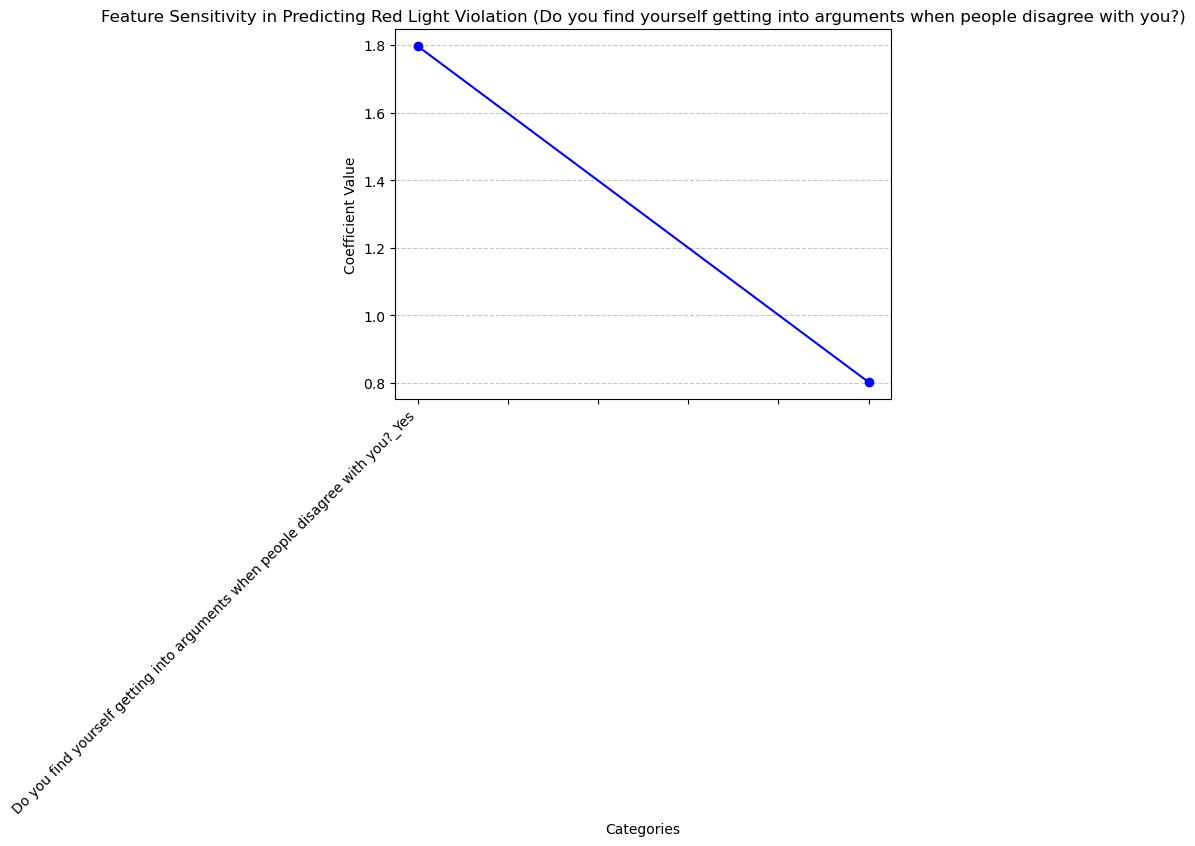

Optimization terminated successfully.
         Current function value: 0.538630
         Iterations 6

Logit Model Summary - Sensitivity Analysis for Driving Experience

                           Logit Regression Results                           
Dep. Variable:      RedLightViolation   No. Observations:                  800
Model:                          Logit   Df Residuals:                      797
Method:                           MLE   Df Model:                            2
Date:                Thu, 06 Mar 2025   Pseudo R-squ.:                 0.03259
Time:                        23:46:35   Log-Likelihood:                -430.90
converged:                       True   LL-Null:                       -445.42
Covariance Type:            nonrobust   LLR p-value:                 4.965e-07
                                           coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------

C:\Users\SAPTARSHI\anaconda3\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


<Figure size 800x500 with 0 Axes>

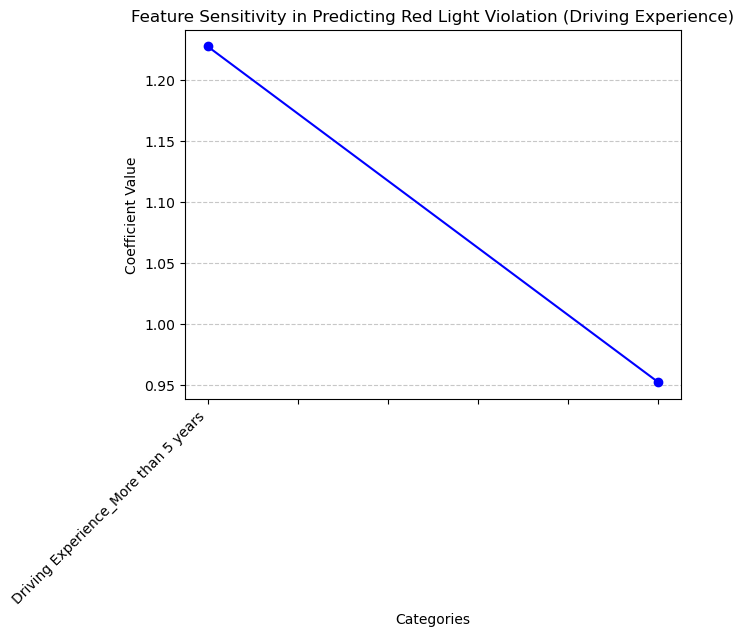

Optimization terminated successfully.
         Current function value: 0.551194
         Iterations 5

Logit Model Summary - Sensitivity Analysis for Which type of intersections do you believe is most prone to red light violations?

                           Logit Regression Results                           
Dep. Variable:      RedLightViolation   No. Observations:                  800
Model:                          Logit   Df Residuals:                      796
Method:                           MLE   Df Model:                            3
Date:                Thu, 06 Mar 2025   Pseudo R-squ.:                 0.01002
Time:                        23:46:35   Log-Likelihood:                -440.95
converged:                       True   LL-Null:                       -445.42
Covariance Type:            nonrobust   LLR p-value:                   0.03023
                                                                                                                        coef    std err

C:\Users\SAPTARSHI\anaconda3\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


<Figure size 800x500 with 0 Axes>

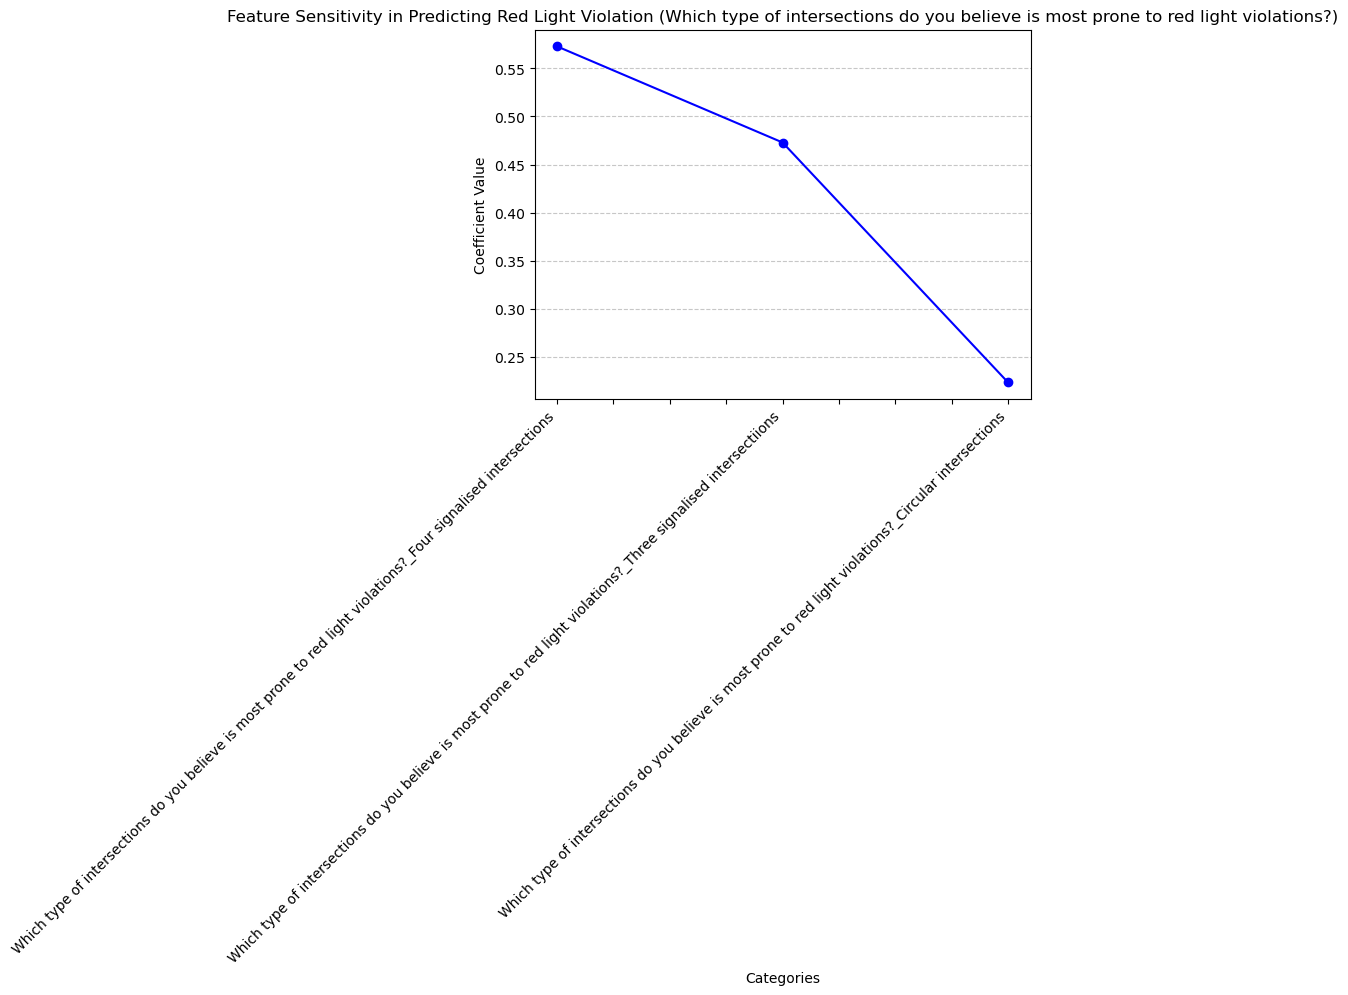

Optimization terminated successfully.
         Current function value: 0.299564
         Iterations 8

Logit Model Summary - Sensitivity Analysis for What are the main reasons that make you more likely to cross during a red light?

                           Logit Regression Results                           
Dep. Variable:      RedLightViolation   No. Observations:                  800
Model:                          Logit   Df Residuals:                      793
Method:                           MLE   Df Model:                            6
Date:                Thu, 06 Mar 2025   Pseudo R-squ.:                  0.4620
Time:                        23:46:35   Log-Likelihood:                -239.65
converged:                       True   LL-Null:                       -445.42
Covariance Type:            nonrobust   LLR p-value:                 9.236e-86
                                                                                                                                     coe

C:\Users\SAPTARSHI\anaconda3\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


<Figure size 800x500 with 0 Axes>

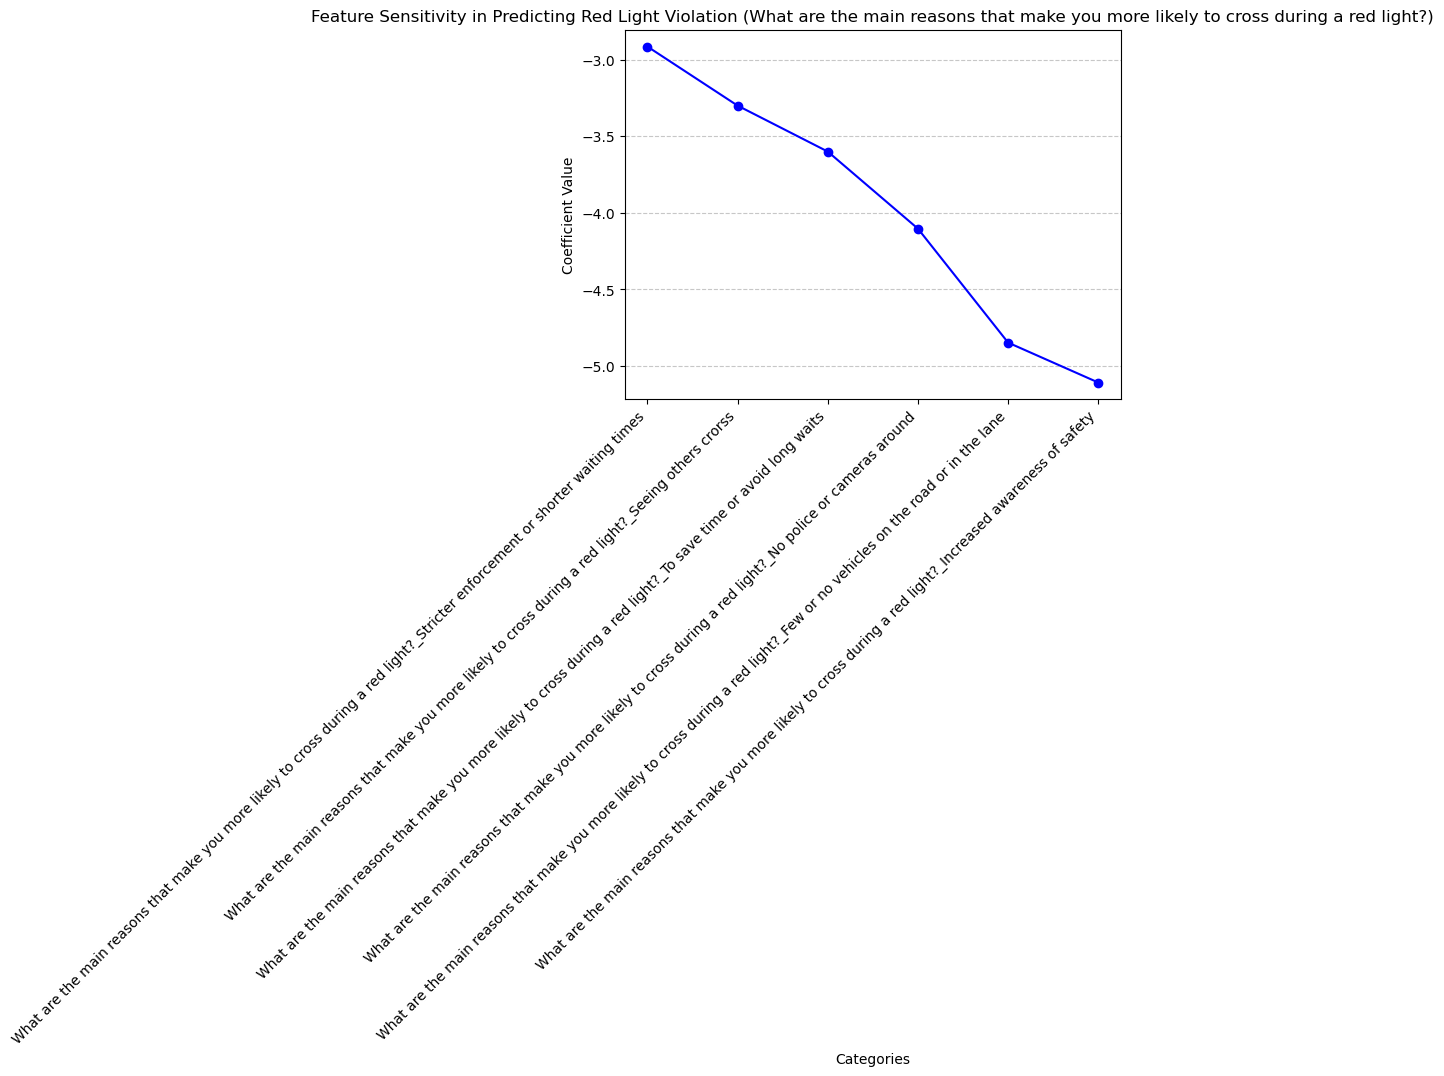

In [38]:
analyze_sensitivity(selected_cols)